In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

import keras
from keras.layers import Dense, Activation, Convolution2D, Reshape, Flatten, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D, Input, Dropout
from keras.models import Sequential, Model

Using TensorFlow backend.


In [2]:
ds = pd.read_csv('../train.csv')
data = ds.values[:1000]

In [3]:
print data.shape
X = data[:, 1:]
X = X.reshape((X.shape[0], 28, 28, 1))

(1000, 785)


In [4]:
def convert_color(col):
    # convert from 0-255 to 0-15
    return col/16

#X_ = X/16
#print X_.mean(), X_.max(), X_.min()

X_new = np.zeros((X.shape[0], 28, 28, 256))

for ix in range(X_new.shape[0]):
    for ir in range(28):
        for ic in range(28):
            col = X[ix, ir, ic]
            X_new[ix, ir, ic, col] = 1
print X_new.shape

(1000, 28, 28, 256)


In [5]:
X = X_new

In [6]:
split = int(0.65 * X.shape[0])
X_train = X[:split]
X_val = X[split:]

print X_train.shape, X_val.shape

(650, 28, 28, 256) (350, 28, 28, 256)


In [16]:
# Autoencoder
embedding_shape = 3

inp = Input(shape=(28, 28, 256))

#--------- Encoder ------------------#
c1 = Convolution2D(128, 3, 3, activation='relu')(inp)
c2 = Convolution2D(64, 3, 3, activation='relu')(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(c2)
c3 = Convolution2D(8, 3, 3, activation='relu')(m1)

#---------- Embedding ----------------#
#f1 = Flatten()(c3)
#f1 = Dropout(0.4)(f1)

#fc1 = Dense(embedding_shape, activation='sigmoid')(f1)
#fc2 = Dense(800, activation='relu')(fc1)

#rs = Reshape((10, 10, 8))(fc2)

#--------- Decoder -------------------#
zp1 = ZeroPadding2D(padding=(1, 1))(c3)
dc1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(zp1)
up1 = UpSampling2D(size=(2, 2))(dc1)

zp2 = ZeroPadding2D(padding=(1, 1))(up1)
dc2 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(zp2)

zp3 = ZeroPadding2D(padding=(1, 1))(dc2)
dc3 = Convolution2D(256, 3, 3, border_mode='same', activation='sigmoid')(zp3)

out = dc3

model = Model(input=inp, output=out)
model.summary()
#encoder = Model(input=inp, output=fc1)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 28, 28, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 26, 26, 128)   295040      input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 24, 24, 64)    73792       convolution2d_31[0][0]           
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 12, 12, 64)    0           convolution2d_32[0][0]           
___________________________________________________________________________________________

In [68]:
dec_in = Input(shape=(embedding_shape,))

x = model.layers[8](dec_in)

for ix in range(9, len(model.layers)):
    x = model.layers[ix](x)

decoder = Model(input=dec_in, output=x)
# decoder.summary()

In [17]:
hist = model.fit(X_train, X_train,
                nb_epoch=10,
                shuffle=True,
                batch_size=100,
                validation_data=(X_val, X_val), verbose=2)

Train on 650 samples, validate on 350 samples
Epoch 1/10
8s - loss: 0.2300 - acc: 0.5212 - val_loss: 0.1036 - val_acc: 0.8026
Epoch 2/10
6s - loss: 0.0410 - acc: 0.8057 - val_loss: 0.0044 - val_acc: 0.8026
Epoch 3/10
6s - loss: 0.0028 - acc: 0.8057 - val_loss: 0.0018 - val_acc: 0.8026
Epoch 4/10
6s - loss: 0.0016 - acc: 0.8057 - val_loss: 0.0016 - val_acc: 0.8026
Epoch 5/10
7s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026
Epoch 6/10
6s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026
Epoch 7/10
7s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026
Epoch 8/10
7s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026
Epoch 9/10
7s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026
Epoch 10/10
7s - loss: 0.0015 - acc: 0.8057 - val_loss: 0.0015 - val_acc: 0.8026


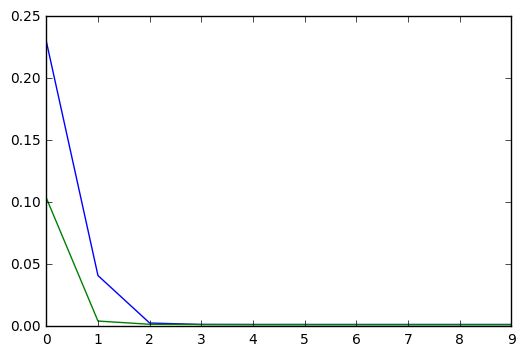

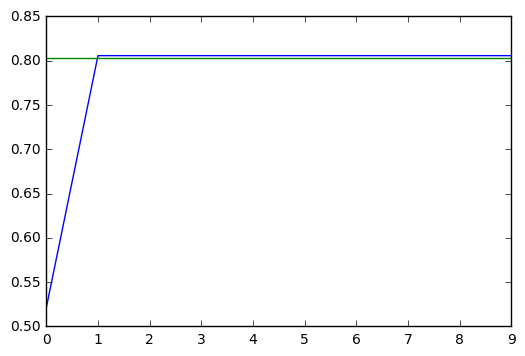

In [18]:
th = hist.history

plt.figure(0)
plt.plot(th['loss'], 'b')
plt.plot(th['val_loss'], 'g')

plt.figure(1)
plt.plot(th['acc'], 'b')
plt.plot(th['val_acc'], 'g')

In [20]:
emb = model.predict(X_train[:10])
print emb.shape

(10, 28, 28, 256)


In [36]:
new_emb = np.random.sample((10, embedding_shape))
print new_emb.shape

(10, 32)


In [55]:
def convert_back(col):
    return 8*(2*col + 1)

In [72]:
out = decoder.predict(emb)
print out.shape

(1000, 28, 28, 16)


In [23]:
ot = np.zeros((emb.shape[0], 28, 28, 1))

for ix in range(emb.shape[0]):
    for ir in range(28):
        for ic in range(28):
            col = emb[ix, ir, ic].argmax()
            ot[ix, ir, ic] = col
print ot.max()

0.0


In [74]:
out = ot
print out[1].reshape((28, 28))

[[ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
   8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8

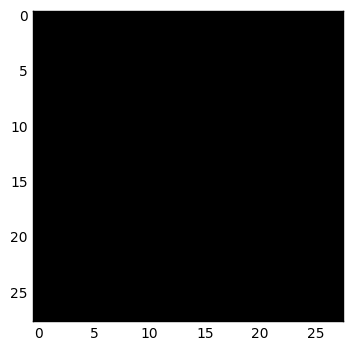

In [76]:
ix = 10
#plt.subplot(1, 2, 1)
plt.imshow(out[ix].reshape((28, 28)), cmap='gray')
#plt.subplot(1, 2, 2)
#plt.imshow(X_train[ix].reshape((28, 28)), cmap='gray')
plt.show()